# Modeling (ResNet)

This time, I trained my data using the Residual Net. The only difference in terms of the implementation from 2. Train U-Net Model on Radarsat Data is that there is transfer learning this time.

In [1]:
# import cv2
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import rasterio
import shapely.geometry
from sklearn.model_selection import train_test_split

import h5py # just a safety check so the checkpoint callback doesnt crash
from scipy.misc import imresize
import tensorflow as tf
print(tf.__version__)

%matplotlib inline

1.2.0


# Dataset

In [21]:
dir_path1 = 'training_tiles/'
np_files1 = [os.path.join(path,f[:f.find('_img.npy')])
             for path,_,files in os.walk(dir_path1) 
             for f in files if (f.endswith('img.npy'))]
dir_path2 = 'training_tiles2/'
np_files2 = [os.path.join(path,f[:f.find('_img.npy')])
             for path,_,files in os.walk(dir_path2) 
             for f in files if (f.endswith('img.npy'))]


In [22]:
def scale_bands(img, lower_pct = 1, upper_pct = 99):
    """
    Rescale the bands of a multichannel image for display
    """
    # Loop through the image bands, rescaling each one
    img_scaled = np.zeros(img.shape, np.uint8)
    
    for i in range(img.shape[2]):
        
        band = img[:, :, i]
        
        # Pick out the lower and upper percentiles
        lower, upper = np.percentile(band, [lower_pct, upper_pct])
        
        # Normalize the band
        band = (band - lower) / (upper - lower) * 255
        
        # Clip the high and low values, and cast to uint8
        img_scaled[:, :, i] = np.clip(band, 0, 255).astype(np.uint8)
        
    return img_scaled

def resize(img, new_shape):
    img_resized = np.zeros(new_shape+(img.shape[2],)).astype('float32')
    for i in range(img.shape[2]):
        img_resized[:, :, i] = imresize(img[:, :, i], new_shape, interp='bicubic')
    return img_resized

def make_set(files, training_size, test_size,input_size):
    X=[]
    Y=[]
    maskz = []
    tile_to_use = np.random.choice(files, size=(training_size+test_size), replace=False)
    for tile_no in tile_to_use:
        img = np.load(tile_no +'_img.npy')
        img = resize(img, (input_size, input_size))
        
        mask = np.load(tile_no +'_mask.npy')
        mask = imresize(mask, (input_size, input_size))
        
        maskz = mask[..., None]
        #maskz = np.concatenate(mask[..., None], axis=2)
        
        X.append(img[None,...])
        Y.append(maskz[None,...])
    
    # Concatenate the results
    X = np.concatenate(X, axis = 0)
    Y = np.concatenate(Y, axis = 0)
    
    # Normalize the values
    X = X.astype('float32')
    X = (X / X.max() - 0.5) * 2   # put X in range [-1, 1]
    Y = Y.astype('float32') / 255 # put Y in range [0, 1]
    
    test_size = test_size/float(training_size+test_size)
    
    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, test_size=test_size, random_state=42)
    
    return X_train, Y_train, X_val, Y_val

In [23]:
input_size = 256
INPUT_SIZE = 256
X_train1, Y_train1, X_val1, Y_val1 = make_set(np_files1, 500, 500, input_size)
X_train2, Y_train2, X_val2, Y_val2 = make_set(np_files2, 500, 500, input_size)

# Model 

The Residual Net won a recent object detection competition on ImageNet but it is also very good for image segmentation. It uses skip connections and learns deviations from the identity layer, hence the term residual. Residual here refers to difference from the identity. Most NN will increase in training error if stacking too many layers, but the Resnet allows for as many stacking as one wants without degradation in performance. Here is the architecture:

<img src="Images/Resnet.png">

### Building Model 

In [5]:
# -*- coding: utf-8 -*-
"""ResNet50 model for Keras.
# Reference:
- [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)
Adapted from code contributed by BigMoyan.
Adapted from Keras.
"""
from __future__ import print_function
from __future__ import absolute_import

import warnings

from keras.layers import Input
from keras import layers
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import (
    decode_predictions, preprocess_input, _obtain_input_shape)

#Transfer learning weights
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels.h5'
WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

#Identity blocks for residual nets, which lets you add as many layers as you want.
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    act_name = 'act' + str(stage)+ block

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu', name=act_name)(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    act_name = 'act' + str(stage) + block

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu', name=act_name)(x)
    return x

Using TensorFlow backend.


In [6]:
# Source: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py

import keras
from keras import backend as K
from keras import applications
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Dropout, Lambda, Add, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from keras.preprocessing.image import ImageDataGenerator
import keras.backend.tensorflow_backend
# if keras.backend.tensorflow_backend._SESSION:
#     tf.reset_default_graph() 
#     keras.backend.tensorflow_backend._SESSION.close()
#     keras.backend.tensorflow_backend._SESSION = None
K.clear_session()
# Set network size params
N_CLASSES = 1
N_CHANNEL = 3

# Define metrics
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return - dice_coef(y_true, y_pred)

def jacc_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def jacc_coef_loss(y_true, y_pred):
    return -jacc_coef(y_true, y_pred)

def jacc_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

def depth_softmax(matrix):
    sigmoid = lambda x: 1 / (1 + K.exp(-x))
    sigmoided_matrix = sigmoid(matrix)
    softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
    return softmax_matrix

# Freeze layers don't want trained
#     for layer in base_model.layers[:3]:
#         layer.trainable = False
def fcn_model(lr=.001):
    K.clear_session()
    
    input_shape = (INPUT_SIZE, INPUT_SIZE, N_CHANNEL)
    
    weights_path = get_file('resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                WEIGHTS_PATH_NO_TOP,
                                cache_subdir='models',
                                md5_hash='a268eb855778b3df3c7506639542a6af')
    bn_axis = 3
    img_input = Input(shape=input_shape)
    
    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    c3 = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(c3, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    c4 = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(c4, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    c5 = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    

    conv_p1 = Conv2D(2048, (1, 1), strides=(1, 1), padding='same', kernel_initializer='he_normal')(c5)
    drop_p1 = Dropout(0.5)(conv_p1)
    
    score_c5 = Conv2D(N_CLASSES, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(drop_p1)
    up_c5 = Conv2DTranspose(N_CLASSES, (2, 2), strides=(2, 2), padding='valid')(score_c5)
    
    score_c4 = Conv2D(N_CLASSES, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(c4)
    fuse_16 = Add()([score_c4, up_c5])
    up_c4 = Conv2DTranspose(N_CLASSES, (2, 2), strides=(2, 2), padding='valid')(fuse_16)
    
    score_c3 = Conv2D(N_CLASSES, (1, 1), strides=(1, 1), padding='same', kernel_initializer='zeros')(c3)
    fuse_32 = Add()([score_c3, up_c4])
    up_c3 = Conv2DTranspose(N_CLASSES, (8, 8), strides=(8, 8), padding='valid', activation='sigmoid')(fuse_32)


    #fcn_model = Sequential()
    fcn_model = Model(inputs=img_input, outputs=up_c3)
    
    fcn_model.load_weights(weights_path, by_name=True)
    #fcn_model.load_weights('.../checkpoints/weights.49-0.09893.hdf5', by_name=False)
    
    fcn_model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=[jacc_coef_int])
    
    return fcn_model

### Training Model 

In [9]:
lr = 0.001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
              patience=3, min_lr=0.000001)

if not os.path.exists('.../res_checkpoints'):
    os.makedirs('.../res_checkpoints')
model_checkpoint = ModelCheckpoint(os.path.join('.../res_checkpoints', 'weights.{epoch:02d}-{loss:.5f}.hdf5'),
                                  monitor='loss', save_best_only=True)

NUM_EPOCHS = 100
### gen = ImageDataGenerator()
### train_batches = gen.flow(X_train, Y_train)
tensorboard = TensorBoard(log_dir='/tmp/tboard_logs2', histogram_freq=0, write_graph=True, write_images=True)
STEPS_PER_EPOCH = X_train.shape[0] / 32
VALIDATION_STEPS = len(X_val) / 32
INPUT_SIZE = 256

model = fcn_model(lr=.0001)
model.fit(X_train, Y_train, batch_size=12, epochs=NUM_EPOCHS, verbose=1, shuffle=True, validation_data=(X_val, Y_val),
         callbacks=[reduce_lr, model_checkpoint, tensorboard])

Train on 5000 samples, validate on 500 samples
Epoch 1/100
5000/5000 [==============================] - 103s - loss: 0.6463 - jacc_coef_int: 0.0022 - val_loss: 0.5733 - val_jacc_coef_int: 0.0021
Epoch 2/100
5000/5000 [==============================] - 96s - loss: 0.4706 - jacc_coef_int: 0.0024 - val_loss: 0.3616 - val_jacc_coef_int: 0.0029
Epoch 3/100
5000/5000 [==============================] - 96s - loss: 0.2308 - jacc_coef_int: 0.0045 - val_loss: 0.0724 - val_jacc_coef_int: 0.0120
Epoch 4/100
5000/5000 [==============================] - 94s - loss: 0.0317 - jacc_coef_int: 0.0502 - val_loss: 0.0230 - val_jacc_coef_int: 0.0818
Epoch 5/100
5000/5000 [==============================] - 94s - loss: 0.0225 - jacc_coef_int: 0.0866 - val_loss: 0.0214 - val_jacc_coef_int: 0.1012
Epoch 6/100
5000/5000 [==============================] - 94s - loss: 0.0214 - jacc_coef_int: 0.0922 - val_loss: 0.0205 - val_jacc_coef_int: 0.1048
Epoch 7/100
5000/5000 [==============================] - 94s - loss: 0

KeyboardInterrupt: 

# View some output

In [7]:
# # If you need to load the model, you can use these lines.  Change the weights filename to match one you have.
model = fcn_model(lr=.0001)
model.load_weights('/mnt/usb-WD_My_Passport_0820_57584A3145413348454B5A32-0:0-part1/Morgan\'s Files/Satellite_Roads_Segmentation/res_checkpoints/weights.35-0.01661.hdf5')

In [10]:
from sklearn.metrics import jaccard_similarity_score
# Function to create an iterator with examples
def jacc_coef_int(y_true, y_pred):
    y_pred_pos = y_pred
    intersection = np.sum(y_true * y_pred_pos)
    sum_ = np.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return np.mean(jac)
def get_examples():
    for i in range(Y_val.shape[0]):
        if Y_val[i, ...].sum() > 100:
            X = X_val[i]
            Y = Y_val[i]
            yield X, Y

# Function to plot a single example
def plot_example(X, Y, model):
    # Apply the model to this example
    prediction = model.predict(X[None, ...])[0, ...] > 0.15
    prediction = prediction * 1
    
    fig, axes = plt.subplots(1, 3, figsize=(10,10))
    
    # Iterate through each target class
    for tno in range(1):
        targ = Y[:, :, tno]
        pred = prediction[:, :, tno]
        
        jaccard_score1 = jaccard_similarity_score(targ.astype('uint8'),pred.astype('uint8'))
        jaccard_score2 = jacc_coef_int(targ,pred)
        plt.suptitle('Jaccard Sim (SKlearn): '+ str(jaccard_score1)+' | Jaccard Sim (Custom): '+ str(jaccard_score2),size=18)
        
        ax1, ax2, ax3 = axes[:]

        ax1.imshow(scale_bands(X[:, :, :])) # This index starts at 0, so I had to decrement
        ax2.imshow(targ, vmin=0, vmax=1, cmap=plt.cm.gray)
        ax3.imshow(pred, vmin=0, vmax=1, cmap=plt.cm.gray)
        
        ax1.set_title('Image')
        ax2.set_title('Ground Truth')
        ax3.set_title('Prediction')
        
        fig.tight_layout()
        plt.subplots_adjust(top=1.55)
    
    plt.show()

    
example_generator = get_examples()


In this case, the residual net does a better job at minimicking the original ground truth, almost like its behaving like the Radarsat, learning even its flaws. This is overfitting in the classic sense. 

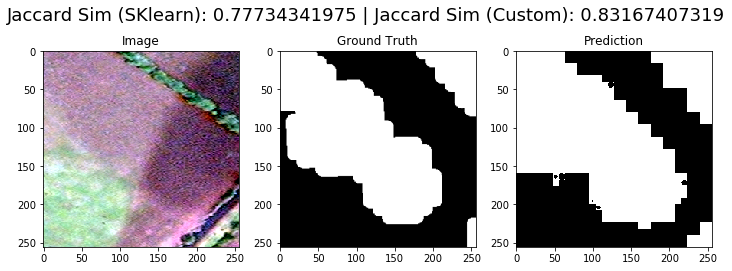

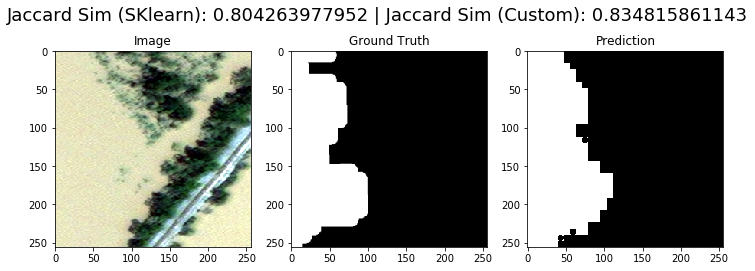

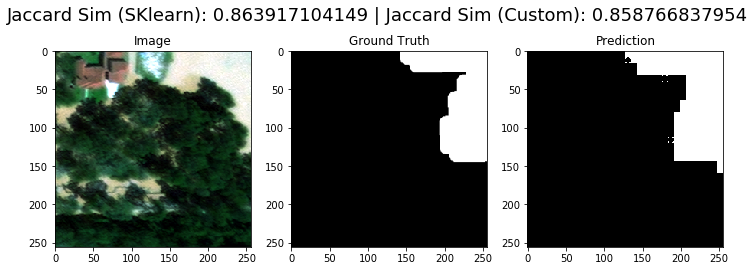

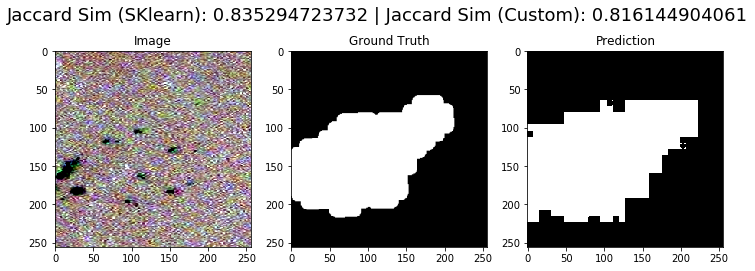

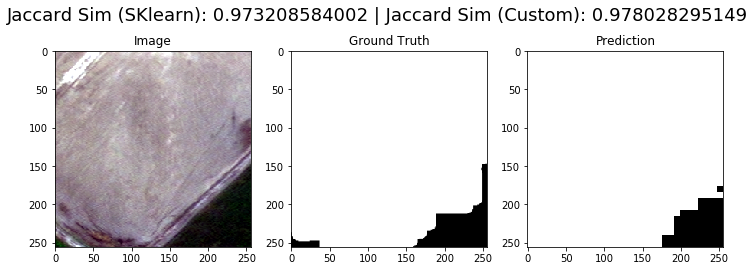

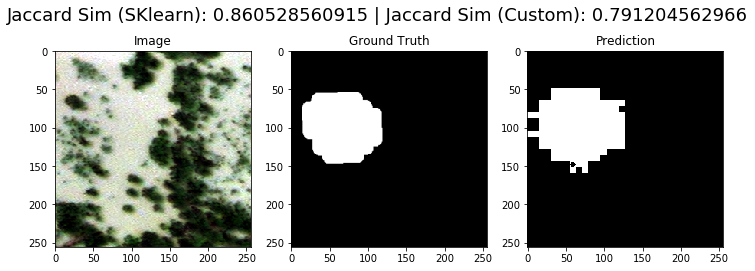

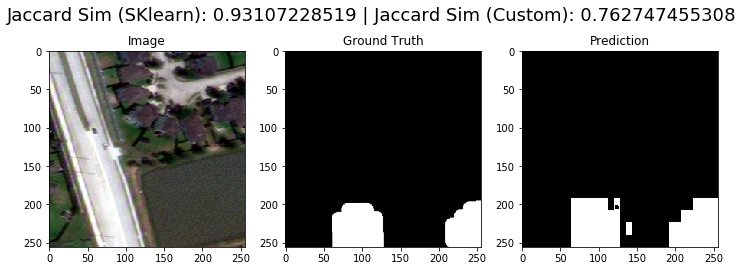

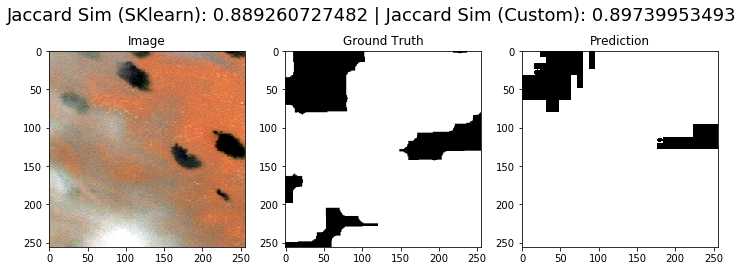

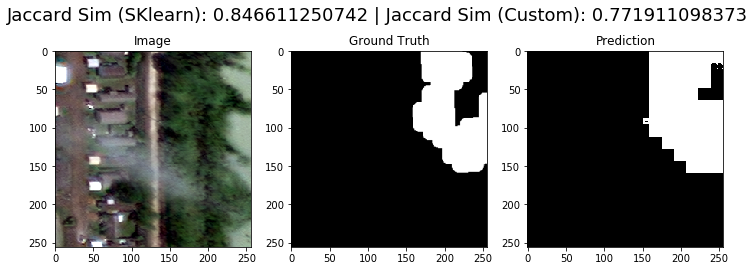

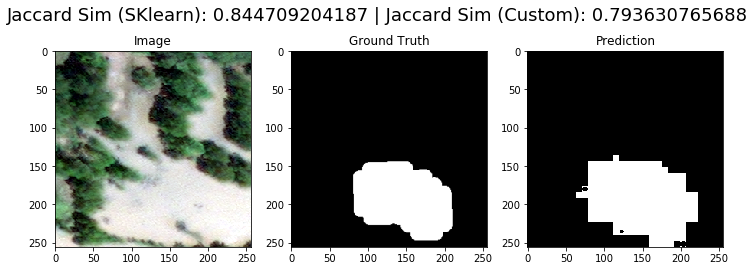

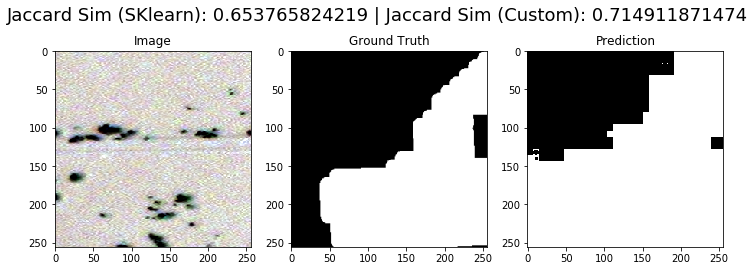

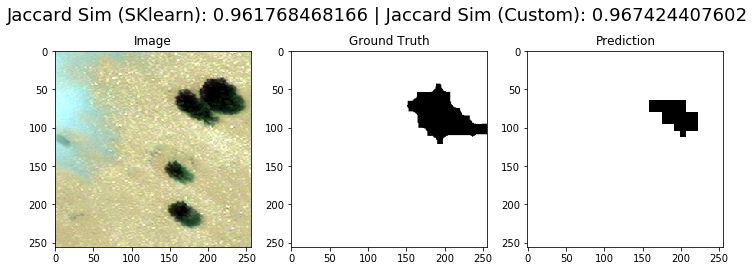

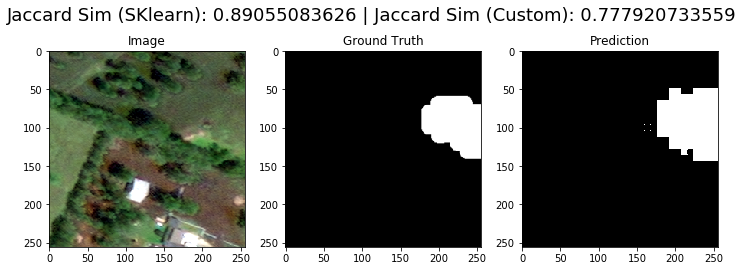

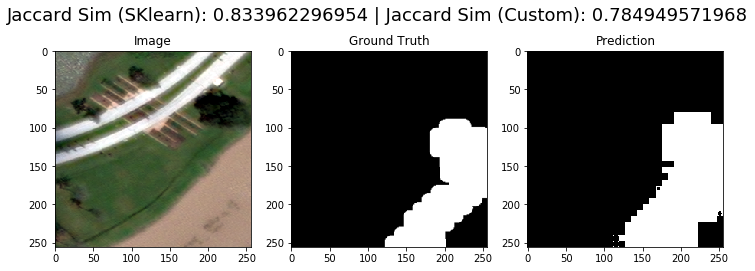

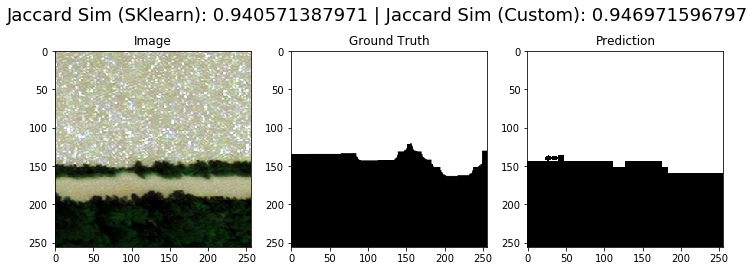

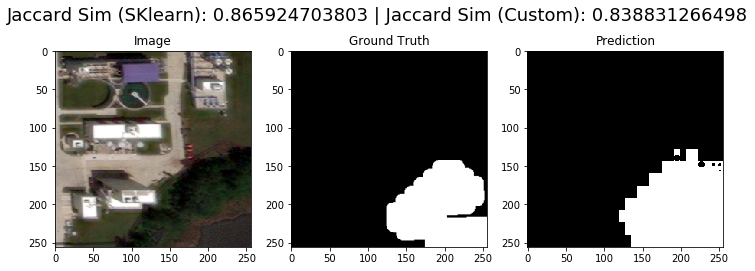

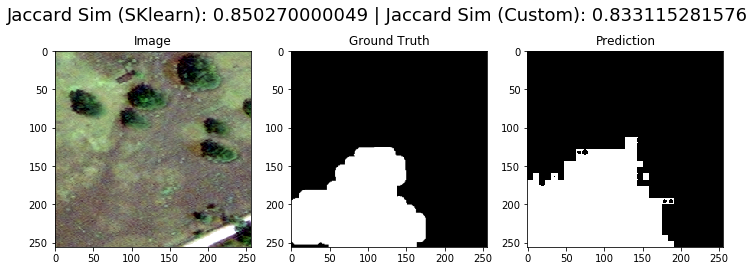

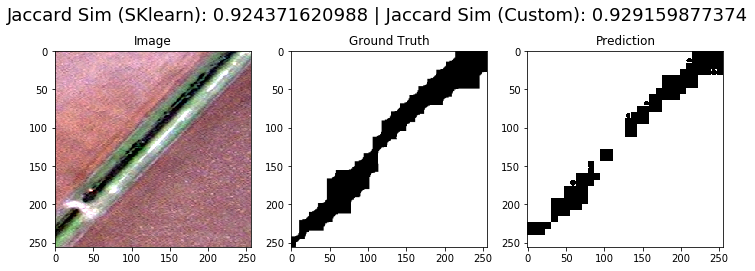

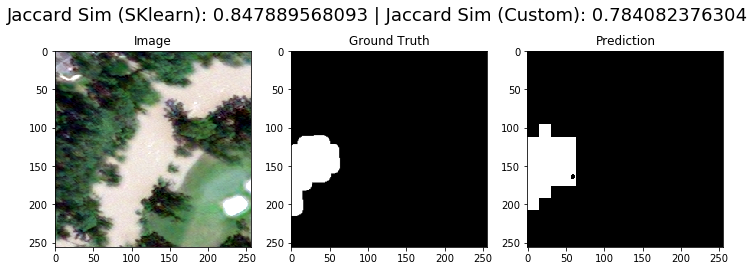

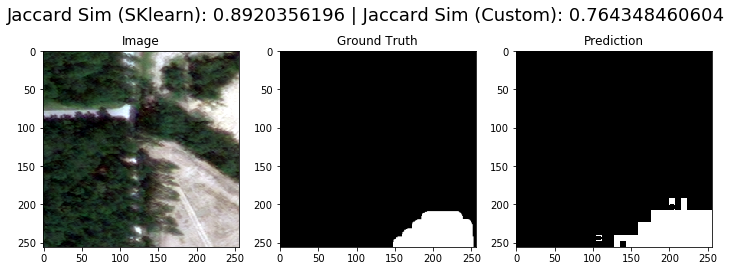

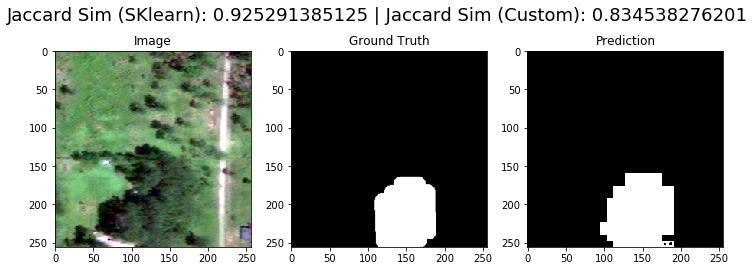

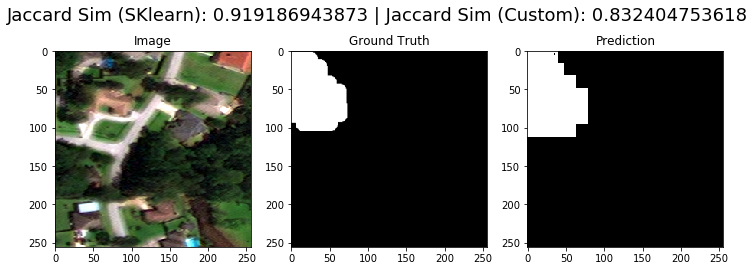

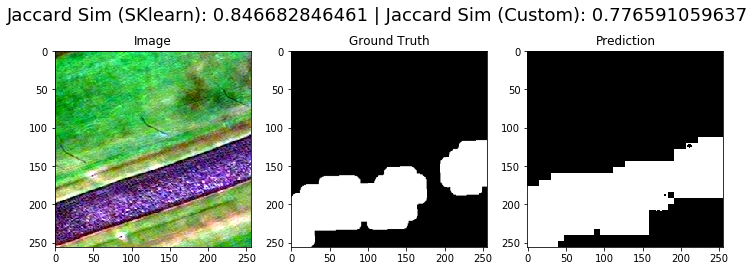

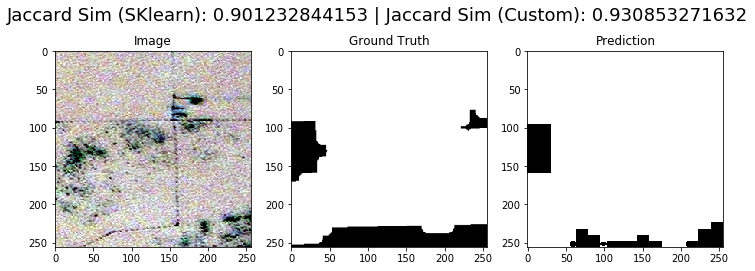

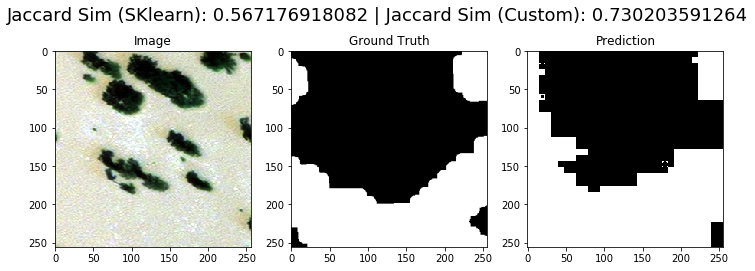

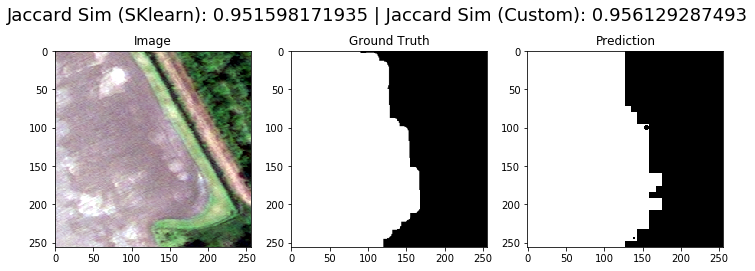

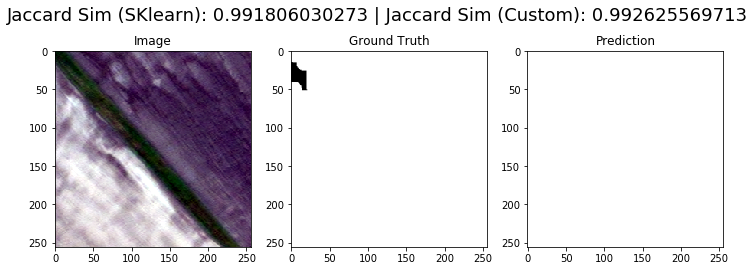

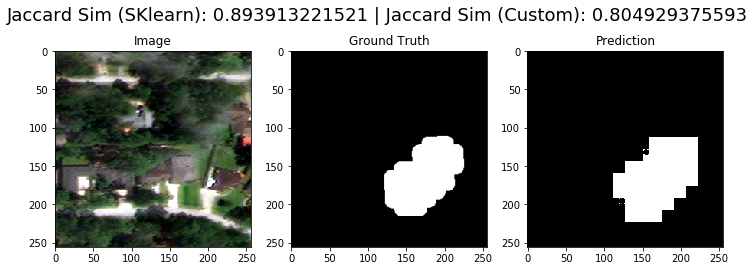

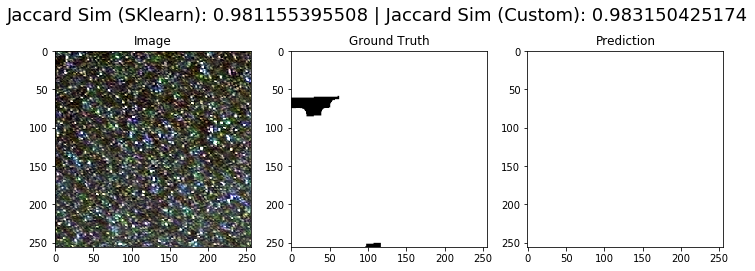

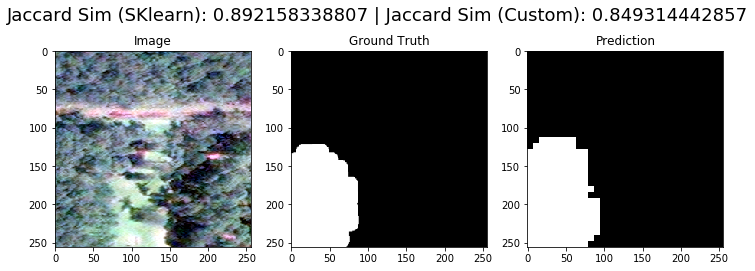

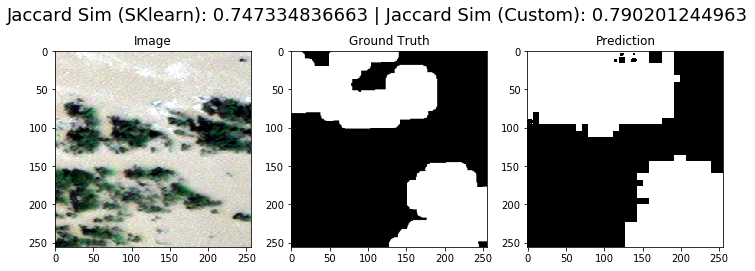

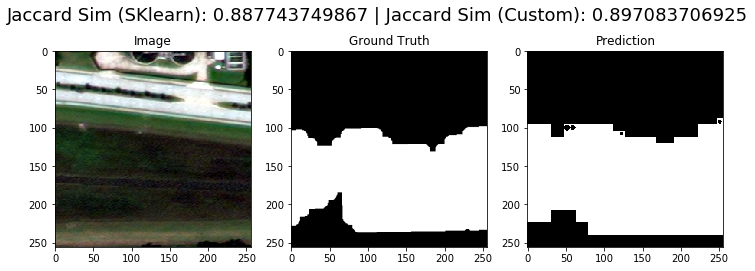

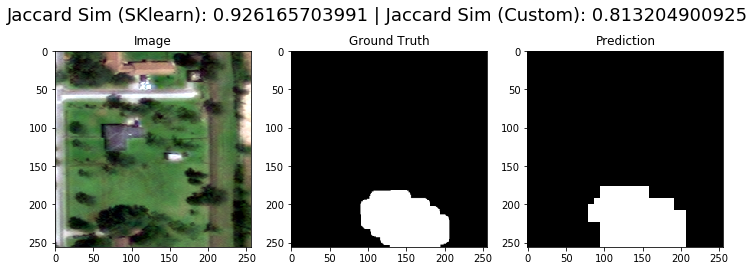

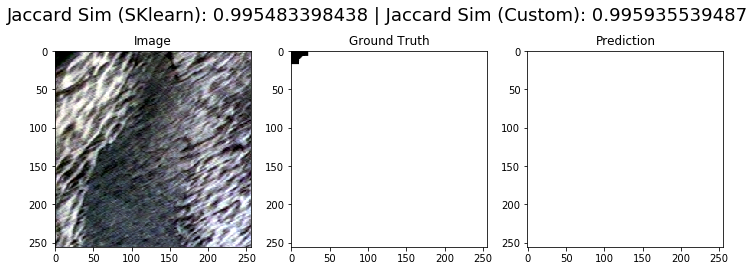

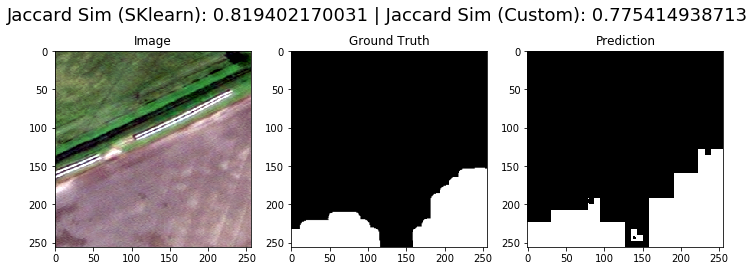

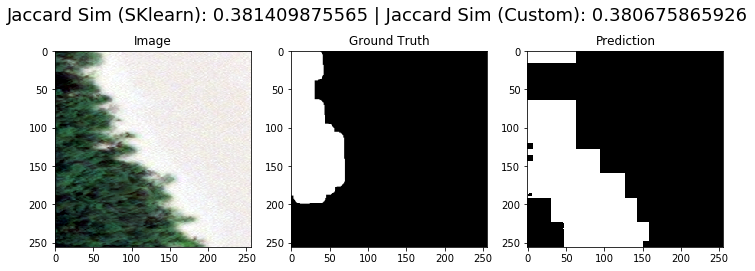

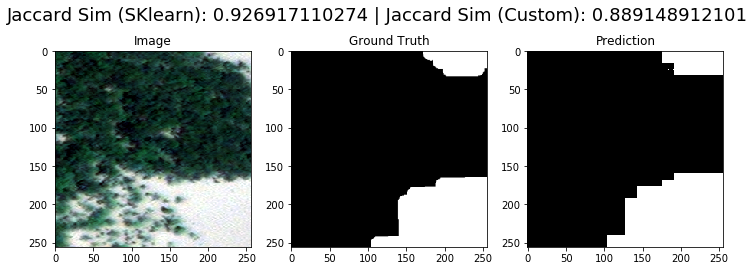

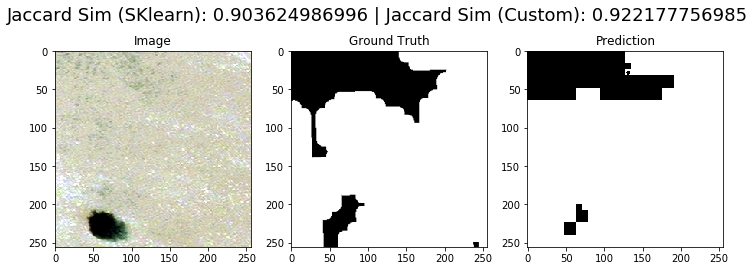

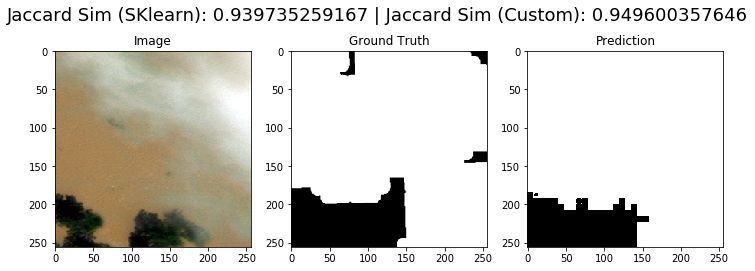

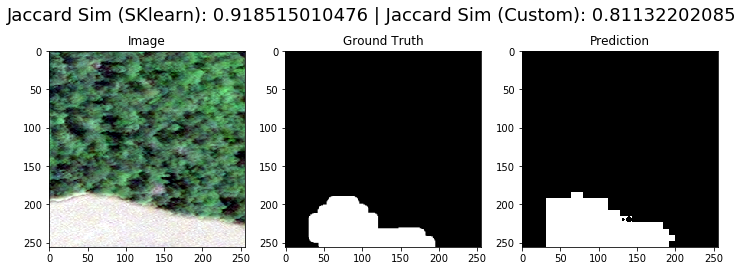

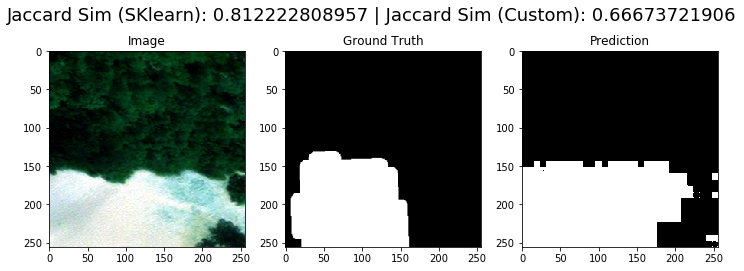

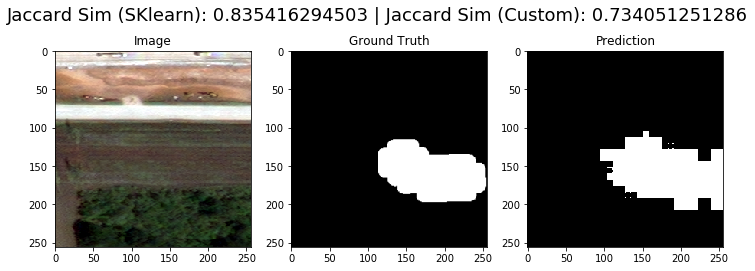

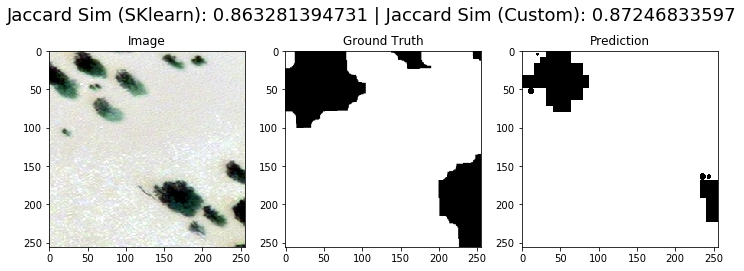

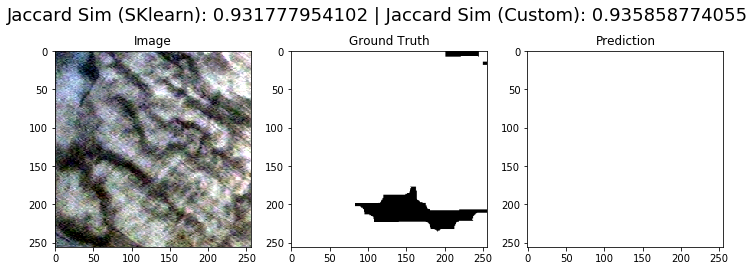

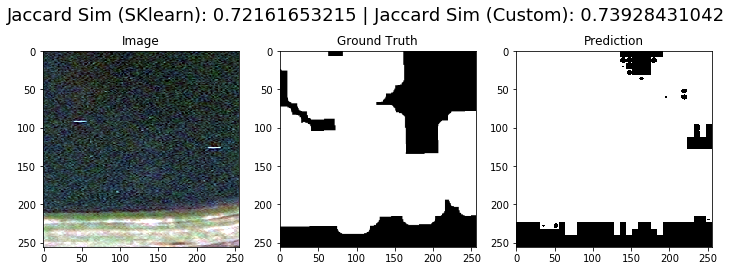

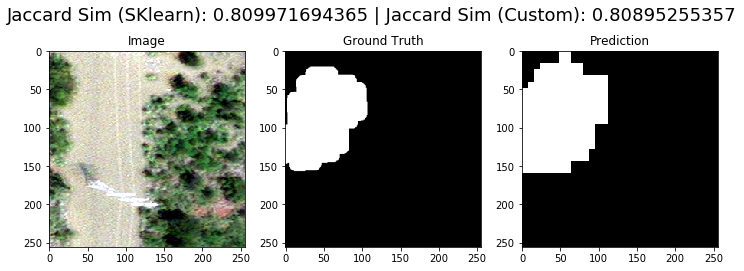

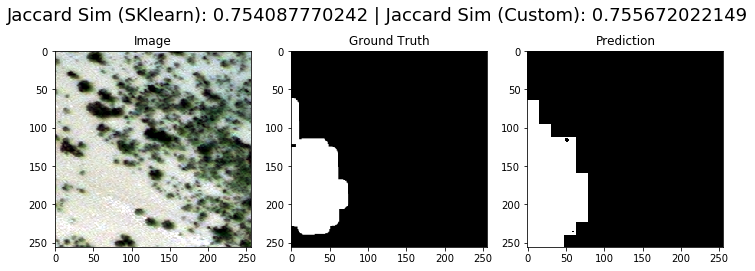

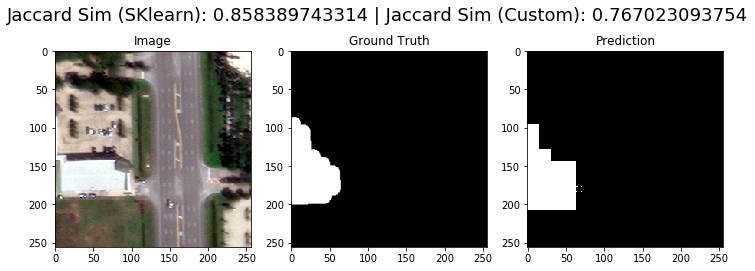

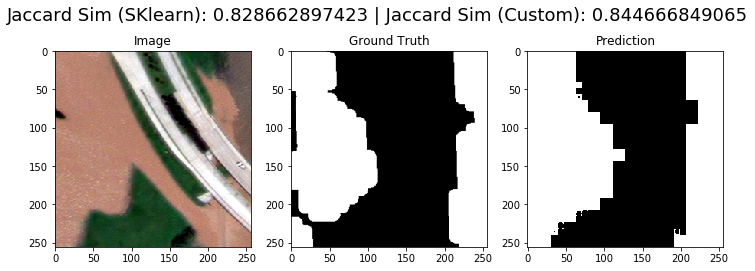

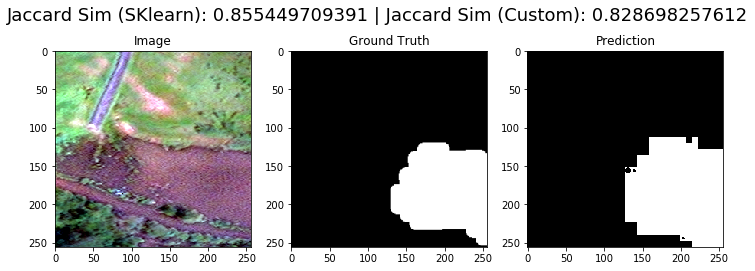

In [12]:
i = 0
while i < 50:
    X, Y = next(example_generator)
    plot_example(X, Y, model)
    i+= 1